# Clinical trial design optimization 

## Loading dependencies

In [1]:
# Cookbook specifics imports
import jinko_helpers as jinko
import io
import math
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.colors as colors
import scipy.stats as st
from sklearn.neighbors import KNeighborsRegressor, KDTree
from sklearn.preprocessing import StandardScaler
import zipfile
import textwrap

## Defining general parameters

In [2]:
# Jinko trial short ID, URL pattern is "https://jinko.ai/{trial_sid}"
trial_sid = "tr-HLRF-b0zW"
# Outcome ID
outcome_name = "tumorBurdenChangeFromBaseline.tend"
# control and treated arm IDs
control_arm_id = "sc-1-10"
treated_arm_id = "iv-1-10"

"""
Sample size parameters
"""
alpha = 0.05
beta = 0.2
dropout = 0  # drop-out ratio

""" 
Efficacy measure. Depending on the use-case, 
"""


def efficacy(outcome_control, outcome_treated):
    return outcome_control - outcome_treated


class Descriptor:
    def __init__(self, identifier, arm=None):
        self.identifier = identifier
        self.arm = arm
        self.column_id = (
            self.identifier if self.arm is None else f"{self.identifier}_{self.arm}"
        )
        self.arm_id = "crossArms" if self.arm is None else self.arm
        self.lower_bound_id = f"{self.column_id}_lower_bound"
        self.width_id = f"{self.column_id}_width"

    def format_descriptor(self):
        if self.arm is not None:
            return f"{self.identifier} on arm {self.arm}"
        else:
            return self.identifier

    def set_lower_bound(self, lower_bound):
        self.lower_bound = lower_bound

    def set_upper_bound(self, upper_bound):
        self.upper_bound = upper_bound


all_descriptors = [
    Descriptor("initialTumorBurden.tmin"),
    Descriptor("ec50Drug.tmin"),
    Descriptor("initialBloodVolume", arm=control_arm_id),
    Descriptor("Tissue.tmin"),
    Descriptor("kClearanceDrug.tmin"),
]

""" Minimal size of the filtered responder vpop
(number of times the required sample size should be included in the responder vp in terms of nb of patients)
Will be evaluated for each set of eligibility criteria
"""
min_resp_vp_size = 10

"""
Objective function weights
"""
# weight of gross efficacy
efficacy_wt = 1
# weight of standard deviation of gross efficacy
efficacy_sd_wt = 2

"""
Boostrapping parameters
"""
## Number of bootstraps for gross efficacy dispersion estimation
num_bootstraps = 50
## Seed for all random processes
cookbook_seed = 2025

## Defining functions
### Sample size computation

In [3]:
# Definition of sample size computation formulas
## Sample size for two independent samples, continuous outcome
def sample_size_continuous_outcome(alpha, beta, diff_btw_groups, sd_outcome):
    z_alpha = st.norm.ppf(1 - (alpha / 2))
    z_beta = st.norm.ppf(1 - beta)

    return (2 * ((z_alpha + z_beta) / (abs(diff_btw_groups) / sd_outcome)) ** 2) / (
        1 - dropout
    )

### Objective function

In [4]:
# Objective function to be maximized
def objective_function(
    efficacy,
    efficacy_sd,
):
    return (efficacy * efficacy_wt - efficacy_sd * efficacy_sd_wt) / (
        efficacy_wt + efficacy_sd_wt
    )

## Loading trial results from Jinko

In [5]:
jinko.initialize()

# Convert short id to core item id
trial_core_item_id = jinko.get_core_item_id(trial_sid, 1)


# Choose a specific revision. By default we return the last version
revision = None
# Choose a specific label. By default we return the last version
label = "cookbook-v2"
response = jinko.get_project_item(sid=trial_sid, revision=revision, label=label)
trial_core_item_id, trial_snapshot_id = (
    response["coreId"]["id"],
    response["coreId"]["snapshotId"],
)

# Uncomment the following to get the latest completed version instead
# # List all trial versions
# # https://doc.jinko.ai/api/#/paths/core-v2-trial_manager-trial-trialId--status/get
# versions = jinko.make_request(
#     f'/core/v2/trial_manager/trial/{trial_core_item_id["id"]}/status'
# ).json()
# # Get the latest completed version
# try:
#     latest_completed_version = next(
#         (item for item in versions if item["status"] == "completed"), None
#     )
#     if latest_completed_version is None:
#         raise Exception("No completed trial version found")
#     else:
#         simulation_id = latest_completed_version["simulationId"]
#         trial_core_item_id = simulation_id["coreItemId"]
#         trial_snapshot_id = simulation_id["snapshotId"]
# except Exception as e:
#     print(f"Error processing trial versions: {e}")
#     raise

scalars_df = jinko.get_trial_scalars_as_dataframe(
    trial_core_item_id, trial_snapshot_id, scalar_ids=[d.identifier for d in all_descriptors] + [outcome_name]
)
print("Number of rows in the initial table:", len(scalars_df))

Authentication successful


Number of rows in the initial table: 79940


In [6]:
conditions = [
    (scalars_df["armId"] == d.arm_id) & (scalars_df["scalarId"] == d.identifier)
    for d in all_descriptors
]
unpivoted_descriptors_df = scalars_df[np.logical_or.reduce(conditions)]
for d in all_descriptors:
    row_filter = (unpivoted_descriptors_df["armId"] == d.arm_id) & (
        unpivoted_descriptors_df["scalarId"] == d.identifier
    )
    unpivoted_descriptors_df.loc[row_filter] = unpivoted_descriptors_df[
        row_filter
    ].assign(scalarId=d.column_id)
descriptors_df = unpivoted_descriptors_df.pivot(
    index="patientId", columns="scalarId", values="value"
)
outcome_control = (
    scalars_df[
        (scalars_df["armId"] == control_arm_id)
        & (scalars_df["scalarId"] == outcome_name)
    ]
    .assign(scalarId="outcome_control")
    .pivot(index="patientId", columns="scalarId", values="value")
)
outcome_treated = (
    scalars_df[
        (scalars_df["armId"] == treated_arm_id)
        & (scalars_df["scalarId"] == outcome_name)
    ]
    .assign(scalarId="outcome_treated")
    .pivot(index="patientId", columns="scalarId", values="value")
)
main_df = pd.merge(
    left=pd.merge(
        left=descriptors_df, right=outcome_control, how="left", on="patientId"
    ),
    right=outcome_treated,
    how="left",
    on="patientId",
).dropna()
display(main_df)

scalarId,Tissue.tmin,ec50Drug.tmin,initialBloodVolume_sc-1-10,initialTumorBurden.tmin,kClearanceDrug.tmin,outcome_control,outcome_treated
patientId,,,,,,,
00136fc9-bdec-9dc8-55ff-7369d623c683,0.512544,0.000296,0.928491,52.434651,0.066257,-88.728631,-90.534356
001b750e-63f4-2e55-44e9-e06b3040a4c1,0.453080,0.000283,0.821033,45.538920,0.066907,-90.717210,-92.146996
001ce12c-93db-aa0d-d970-c234d7bd8ad3,0.487869,0.000287,0.926928,68.267182,0.083475,-92.896515,-94.517458
001dffcb-5592-4385-d0e0-fb89182cf765,0.489147,0.000385,0.889061,44.999893,0.089254,-79.869469,-84.084057
0021f19f-2436-f0dc-3a1f-32bdfee5dfed,0.591238,0.000347,0.978235,69.063116,0.084164,-83.857283,-86.777218
...,...,...,...,...,...,...,...
ffd91588-4368-4d88-bb43-a5f0b8ffae29,0.484973,0.000374,0.878461,40.463993,0.070282,-85.923901,-88.572539
ffdb3a31-17da-92d4-edf2-f4db69abd634,0.554640,0.000294,1.119734,66.129875,0.091793,-85.579723,-88.678879
ffe0bebc-06c3-605b-e5ce-02d993c5647d,0.574689,0.000385,0.917554,110.295227,0.066772,-93.628400,-94.755808


## Trial net efficacy and sample size

In [7]:
mean_control = main_df["outcome_control"].mean()
mean_treated = main_df["outcome_treated"].mean()
initial_net_efficacy = efficacy(mean_control, mean_treated)

std_control = main_df["outcome_control"].std()
std_treated = main_df["outcome_treated"].std()

print(
    f"This trial has a net efficacy of {initial_net_efficacy:.3g} (standard deviation of outcome in control group = {std_control:.2g})"
)
trial_sample_size = math.ceil(
    sample_size_continuous_outcome(alpha, beta, initial_net_efficacy, std_control)
)
print(
    f"With beta = {beta}, this means a sample size of {trial_sample_size} patients per group"
)

This trial has a net efficacy of 2.23 (standard deviation of outcome in control group = 3.3)
With beta = 0.2, this means a sample size of 35 patients per group


## Plotting score proxy

While the actual score function takes the average and standard deviation of the bootstrapped gross efficacy, this is 
rather costly to evaluate (because of the bootstraps).
Here, we leverage the fact that:

  1. the mean of the gross efficacy can be approximated by the mean of the absolute benefit 
  2. the variance of the gross efficacy can be approximated by '(var(outcome_control) + var(outcome_treated)) / sample_size'
to compute a so-called "score proxy"


Using a nearest-neighbor regression with "number of neighbors = sample_size * min_resp_vp_size", the Chebyshev norm and uniform weighting, 
we can compute a score proxy for each trial patient which approximates what the actual score sould be for 
a sub-population of size sample_size centered around each patient

Min score proxy = 0.203, max score proxy = 0.905


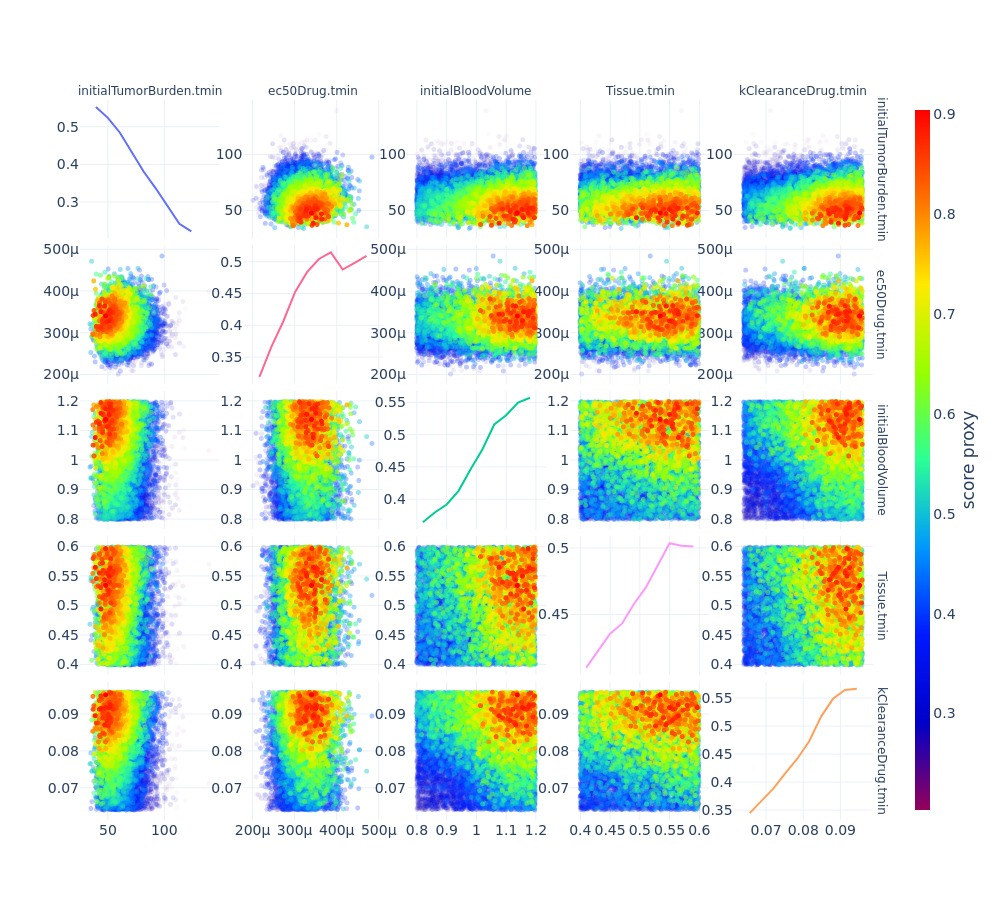

In [8]:
neigh_regressor = KNeighborsRegressor(
    n_neighbors=trial_sample_size * min_resp_vp_size,
    weights="uniform",
    metric="chebyshev",
    n_jobs=4,
)
X_unscaled = main_df[[d.column_id for d in all_descriptors]].to_numpy()
feature_scaler = StandardScaler().fit(X_unscaled)
X = feature_scaler.transform(X_unscaled)
score_proxy = main_df.copy(deep=True)
for arm in ["control", "treated"]:
    neigh_regressor.fit(
        X,
        score_proxy[f"outcome_{arm}"].to_numpy(),
    )
    score_proxy[f"mu_outcome_{arm}"] = neigh_regressor.predict(X)

    neigh_regressor.fit(
        X,
        (score_proxy[f"outcome_{arm}"].to_numpy()) ** 2,
    )
    score_proxy[f"mu_outcome_{arm}_squared"] = neigh_regressor.predict(X)
    score_proxy[f"var_outcome_{arm}"] = (
        score_proxy[f"mu_outcome_{arm}_squared"] - score_proxy[f"mu_outcome_{arm}"] ** 2
    )
# score proxy where the mean of gross efficacy is approximated using the mean of absolute benefit
# and the variance of gross efficacy is approximated as 'var(control) + var(treated) / sample_size'
score_proxy["score_proxy"] = objective_function(
    efficacy(score_proxy[f"mu_outcome_control"], score_proxy[f"mu_outcome_treated"]),
    np.sqrt(score_proxy[f"var_outcome_control"] + score_proxy[f"var_outcome_treated"])
    / np.sqrt(trial_sample_size),
)
min_score, max_score = (
    score_proxy["score_proxy"].min(),
    score_proxy["score_proxy"].max(),
)
print(f"Min score proxy = {min_score:.3g}, max score proxy = {max_score:.3g}")

score_proxy = score_proxy.sort_values(by="score_proxy")
num_features = len(all_descriptors)
features_wrapped = [
    "<br>".join(textwrap.wrap(t.identifier, width=30)) for t in all_descriptors
]
fig = make_subplots(
    num_features,
    num_features,
    shared_xaxes=True,
    shared_yaxes=False,
    horizontal_spacing=0.03,
    vertical_spacing=0.01,
    column_titles=features_wrapped,
    row_titles=features_wrapped,
)

for i in range(num_features):  # iterating over rows
    for j in range(num_features):  # iterating over columns
        if i == j:  # do not plot anything on the diagonal
            x = score_proxy[all_descriptors[i].column_id]
            nx = 10
            xs = np.linspace(x.min(), x.max(), nx + 1)
            y = []
            for k in range(nx):
                eff_k = score_proxy[
                    (score_proxy[all_descriptors[i].column_id] >= xs[k])
                    & (score_proxy[all_descriptors[i].column_id] < xs[k + 1])
                ]["score_proxy"]
                y.append(eff_k.mean())
            fig.add_trace(
                go.Scatter(x=xs[:-1] + 0.5 * (xs[1] - xs[0]), y=y, mode="lines"),
                row=i + 1,
                col=j + 1,
            )
        else:
            fig.add_trace(
                go.Scattergl(
                    x=score_proxy[all_descriptors[j].column_id],
                    y=score_proxy[all_descriptors[i].column_id],
                    mode="markers",
                    marker=dict(
                        size=5,
                        color=score_proxy["score_proxy"],
                        opacity=(score_proxy["score_proxy"] - min_score)
                        / (max_score - min_score),
                        coloraxis="coloraxis1",
                    ),
                    hoverinfo="none",
                ),
                row=i + 1,
                col=j + 1,
            )
fig.update_annotations(font_size=12)
fig.update_coloraxes(
    colorbar_title="score proxy",
    cmin=min_score,
    cmax=max_score,
    colorscale="rainbow",
    colorbar_thickness=15,
    colorbar_title_side="right",
)
fig.update_layout(
    font=dict(size=14),
    showlegend=False,
    width=1000,
    height=900,
    template="plotly_white",
)
fig.show(renderer="jpeg")

## Selecting features

In [9]:
num_features = min(5, len(all_descriptors))
features = all_descriptors[:num_features]
print(f"Selected features: {[feature.identifier for feature in features]}")

for descriptor in features:
    descriptor.set_lower_bound(main_df[descriptor.column_id].min())
    descriptor.set_upper_bound(main_df[descriptor.column_id].max())


class EligibilityCriteria:
    def __init__(self, descriptors: list[Descriptor]):
        self.descriptors = descriptors
        self.criteria_ids = [
            descriptor.lower_bound_id for descriptor in descriptors
        ] + [descriptor.width_id for descriptor in descriptors]
        self.bounds = {}
        for descriptor in descriptors:
            (d_min, d_max) = (descriptor.lower_bound, descriptor.upper_bound)
            self.bounds[descriptor.lower_bound_id] = (
                d_min,
                d_max - 0.1 * (d_max - d_min),
            )
            self.bounds[descriptor.width_id] = (0.1 * (d_max - d_min), d_max - d_min)

    def column_ids(self):
        return [descriptor.column_id for descriptor in ec.descriptors]

    def criteria_from_vector(self, vec: list[float]) -> dict:
        return {criterion_id: x for (criterion_id, x) in zip(self.criteria_ids, vec)}

    def criteria_to_vector(self, criteria: dict) -> list[float]:
        vec = np.zeros((len(self.criteria_ids),))
        for i, criteria_id in enumerate(self.criteria_ids):
            vec[i] = criteria[criteria_id]
        return vec

    def filter_conditions(self, dataframe, criteria):
        conditions = [
            (dataframe[descriptor.column_id] >= criteria[descriptor.lower_bound_id])
            & (
                dataframe[descriptor.column_id]
                <= criteria[descriptor.lower_bound_id] + criteria[descriptor.width_id]
            )
            for descriptor in self.descriptors
        ]
        return np.logical_and.reduce(conditions)

    def format_criteria(self, criteria):
        s = ""
        for descriptor in self.descriptors:
            s += f"\n {criteria[descriptor.lower_bound_id]:.3g} <= {descriptor.format_descriptor()} <= {criteria[descriptor.lower_bound_id] + criteria[descriptor.width_id]:.3g}"
        return s

    # returns the mean and standard deviation of the gross efficacy using the absolute benefit
    def gross_efficacy_using_absolute_benefit(self, dataframe, criteria, sample_size):
        filtered_df = main_df[self.filter_conditions(dataframe, criteria)]
        if len(filtered_df) < sample_size * min_resp_vp_size:
            return (None, None)
        control_filtered = filtered_df["outcome_control"]
        treated_filtered = filtered_df["outcome_treated"]
        mean_efficacy = efficacy(control_filtered.mean(), treated_filtered.mean())
        var_efficacy = (control_filtered.var() + treated_filtered.var()) / sample_size

        return (mean_efficacy, np.sqrt(var_efficacy))

    def score_vector(self, dataframe, sample_size, x):
        criteria = self.criteria_from_vector(x)
        (mean_ge, sd_ge) = ec.gross_efficacy_using_absolute_benefit(
            dataframe, criteria, sample_size
        )
        if mean_ge is not None and sd_ge is not None:
            return objective_function(mean_ge, sd_ge)
        else:
            return np.nan

    # returns the mean and standard deviation of the gross efficacy using bootstrapping
    def gross_efficacy_using_bootstrap(
        self,
        dataframe,
        criteria,
        sample_size,
        seed=cookbook_seed,
        n_boot=num_bootstraps,
    ):
        # A reproducible random generator whose seed depends on the top-level cookbook seed AND the criteria
        seeds = [seed, abs(hash(frozenset(criteria.items())))]
        filtered_df = main_df[self.filter_conditions(dataframe, criteria)]
        if len(filtered_df) < sample_size * min_resp_vp_size:
            return (None, None)
        else:
            return self.bootstrapped_efficacy(filtered_df, sample_size, seeds, n_boot)

    def bootstrapped_efficacy(
        self,
        dataframe,
        sample_size,
        seeds,
        n_boot=num_bootstraps,
    ):
        control_filtered = dataframe["outcome_control"]
        treated_filtered = dataframe["outcome_treated"]
        rng = np.random.default_rng(seeds)
        bootstrap_gross_efficacies = []
        all_indices = np.arange(len(control_filtered))
        for _ in range(n_boot):
            # pick 2 * sample_size indices at random from the full dataset
            shuffled_indices = rng.choice(
                all_indices, size=2 * sample_size, replace=False
            )
            # first sample_size indices for the control sub-group
            ctrl_mean = control_filtered.iloc[shuffled_indices[:sample_size]].mean()
            # next sample_size indices for the treated sub-group
            trtd_mean = treated_filtered.iloc[
                shuffled_indices[sample_size : 2 * sample_size]
            ].mean()
            bootstrap_gross_efficacies.append(efficacy(ctrl_mean, trtd_mean))

        return np.mean(bootstrap_gross_efficacies), np.std(
            bootstrap_gross_efficacies, ddof=1
        )

    def net_efficacy(self, dataframe, criteria):
        filtered_df = main_df[self.filter_conditions(dataframe, criteria)]
        net_efficacy_series = efficacy(
            filtered_df["outcome_control"], filtered_df["outcome_treated"]
        )
        mean_efficacy, std_efficacy = (
            net_efficacy_series.mean(),
            net_efficacy_series.std(),
        )
        return (mean_efficacy, std_efficacy)

    def group_size(self, dataframe, criteria):
        filtered_df = main_df[self.filter_conditions(dataframe, criteria)]
        return len(filtered_df)

    def report(self, dataframe, criteria, sample_size, n_boot):
        (mean_ge, sd_ge) = ec.gross_efficacy_using_absolute_benefit(
            dataframe, criteria, sample_size=sample_size
        )
        print(f"\nMean of gross efficacy using absolute benefit = {mean_ge:.3g}")
        print(
            f"Standard deviation of gross efficacy using absolute benefit = {sd_ge:.2g}"
        )
        score_ab = objective_function(mean_ge, sd_ge)
        print(f"Score using absolute benefit = {score_ab:.3g}")

        mean_ge, sd_ge = ec.gross_efficacy_using_bootstrap(
            dataframe, criteria, sample_size=sample_size, n_boot=n_boot
        )
        print(f"\nMean of gross efficacy (with {n_boot} bootstraps) = {mean_ge:.3g}")
        print(
            f"Standard deviation of gross efficacy (with {n_boot} bootstraps) = {sd_ge:.2g}"
        )
        score_bootstrap = objective_function(mean_ge, sd_ge)
        print(f"Score using bootstrap = {score_bootstrap:.3g}")


ec = EligibilityCriteria(descriptors=features)

Selected features: ['initialTumorBurden.tmin', 'ec50Drug.tmin', 'initialBloodVolume', 'Tissue.tmin', 'kClearanceDrug.tmin']


## Eligibility criteria optimization using score proxy

In [10]:
imax = score_proxy["score_proxy"].argmax()
print(f"Best score proxy = {score_proxy.iloc[imax]["score_proxy"]:.3g}")
x0_unscaled = score_proxy.iloc[imax][ec.column_ids()].to_numpy()

X_unscaled = score_proxy[ec.column_ids()].to_numpy()
feature_scaler = StandardScaler().fit(X_unscaled)
X = feature_scaler.transform(X_unscaled)
neigh_regressor.fit(X, score_proxy["outcome_control"].to_numpy())

x0_scaled = feature_scaler.transform(np.reshape(x0_unscaled, (1, x0_unscaled.size)))
distances, indices = neigh_regressor.kneighbors(
    x0_scaled, n_neighbors=trial_sample_size * min_resp_vp_size
)

score_proxy_criteria = {}
for i, descriptor in enumerate(ec.descriptors):
    min_f, max_f = np.amin(X_unscaled[indices[0, :], i]), np.amax(
        X_unscaled[indices[0, :], i]
    )
    score_proxy_criteria[descriptor.lower_bound_id] = min_f
    score_proxy_criteria[descriptor.width_id] = max_f - min_f

ec.report(main_df, score_proxy_criteria, sample_size=trial_sample_size, n_boot=100)

Best score proxy = 0.905

Mean of gross efficacy using absolute benefit = 3.92
Standard deviation of gross efficacy using absolute benefit = 0.6
Score using absolute benefit = 0.904

Mean of gross efficacy (with 100 bootstraps) = 3.77
Standard deviation of gross efficacy (with 100 bootstraps) = 0.64
Score using bootstrap = 0.83


### Monte Carlo fine tuning

In [11]:
rng = np.random.default_rng([cookbook_seed])
num_mc = 10000
exploration_scale = 0.02

x0 = ec.criteria_to_vector(score_proxy_criteria)
dim = len(ec.criteria_ids)
X_mc = rng.normal(loc=x0, scale=np.absolute(x0 * exploration_scale), size=(num_mc, dim))
y = np.array([ec.score_vector(main_df, trial_sample_size, x) for x in X_mc])
mc_i_max = np.nanargmax(y)
print(
    f"MC fine-tuning, number of admissible points = {np.count_nonzero(~np.isnan(y))} / {X_mc.shape[0]}"
)
score_proxy_mc_fine_tuned_criteria = ec.criteria_from_vector(X_mc[mc_i_max])
ec.report(
    main_df,
    score_proxy_mc_fine_tuned_criteria,
    sample_size=trial_sample_size,
    n_boot=100,
)

MC fine-tuning, number of admissible points = 1025 / 10000

Mean of gross efficacy using absolute benefit = 3.9
Standard deviation of gross efficacy using absolute benefit = 0.58
Score using absolute benefit = 0.915

Mean of gross efficacy (with 100 bootstraps) = 3.95
Standard deviation of gross efficacy (with 100 bootstraps) = 0.56
Score using bootstrap = 0.946


## Eligibility criteria optimization using Sobol sequence grid search + MC fine tuning

### Sobol sequence grid search

In [12]:
sampler = st.qmc.Sobol(dim, scramble=False)
m = 14
print(f"Full design size = {2**m}")
scaled_samples = sampler.random_base2(m)  # generates 2**m points


def unscale(x):
    return st.qmc.scale(
        x,
        [ec.bounds[c][0] for c in ec.criteria_ids],
        [ec.bounds[c][1] for c in ec.criteria_ids],
    )


def scale(x):
    return st.qmc.scale(
        x,
        [ec.bounds[c][0] for c in ec.criteria_ids],
        [ec.bounds[c][1] for c in ec.criteria_ids],
        reverse=True,
    )


samples = unscale(scaled_samples)
y = np.array([ec.score_vector(main_df, trial_sample_size, x) for x in samples])
print(
    f"Number of admissible points = {np.count_nonzero(~np.isnan(y))} / {samples.shape[0]}"
)
exhaustive_i_max = np.nanargmax(y)
exhaustive_best_criteria = ec.criteria_from_vector(samples[exhaustive_i_max])
ec.report(
    main_df,
    exhaustive_best_criteria,
    sample_size=trial_sample_size,
    n_boot=100,
)

Full design size = 16384
Number of admissible points = 921 / 16384

Mean of gross efficacy using absolute benefit = 3.74
Standard deviation of gross efficacy using absolute benefit = 0.69
Score using absolute benefit = 0.791

Mean of gross efficacy (with 100 bootstraps) = 3.8
Standard deviation of gross efficacy (with 100 bootstraps) = 0.74
Score using bootstrap = 0.772


### MC fine-tuning

After having found the best point in the Sobol design of experiment, let's search for an even better set of
eligibility criteria around said point

In [13]:
tree = KDTree(scaled_samples)
k = 10
x0 = scaled_samples[exhaustive_i_max, :]
distances, indices = tree.query(np.reshape(x0, (1, x0.size)), k=k)
# distance to kth nearest neighbor
radius = distances[0, k - 1]

rng = np.random.default_rng([cookbook_seed])
num_mc = 10000
# the average squared distance from the mean in a multivariate normal distribution is tr(Σ)
# so by choosing a standard deviation of sigma = radius / sqrt(dim), our sampled points will lie in average
# at a distance of radius from x0
scaled_mc = rng.normal(loc=x0, scale=radius / np.sqrt(dim), size=(num_mc, dim))
scaled_mc[scaled_mc < 0] = 0
scaled_mc[scaled_mc > 1] = 1
X_mc = unscale(scaled_mc)
y = np.array([ec.score_vector(main_df, trial_sample_size, x) for x in X_mc])
mc_i_max = np.nanargmax(y)
print(
    f"MC fine-tuning, number of admissible points = {np.count_nonzero(~np.isnan(y))} / {X_mc.shape[0]}"
)
exhaustive_mc_fine_tuned_criteria = ec.criteria_from_vector(X_mc[mc_i_max])
ec.report(
    main_df,
    exhaustive_mc_fine_tuned_criteria,
    sample_size=trial_sample_size,
    n_boot=100,
)

MC fine-tuning, number of admissible points = 4940 / 10000

Mean of gross efficacy using absolute benefit = 3.87
Standard deviation of gross efficacy using absolute benefit = 0.6
Score using absolute benefit = 0.888

Mean of gross efficacy (with 100 bootstraps) = 3.88
Standard deviation of gross efficacy (with 100 bootstraps) = 0.67
Score using bootstrap = 0.847


## Potential gains

Net efficacy in initial population = 2.23
Mean of gross efficacy (with 50 bootstraps) = 2.07
Standard deviation of gross efficacy (with 50 bootstraps) = 0.76
Required sample size in initial population = 35

Eligibility criteria using Sobol design exhaustive search + MC fine-tuning:
  Number of unique best responding patients: 406
  Mean of gross efficacy (50 bootstraps) = 3.88
  Standard deviation of gross efficacy (50 bootstraps) = 0.69
  Net efficacy in the population of best responders = 3.87
    --> gain in net efficacy = 1.64 (+73%)
  Required sample size in population of best responders = 9
    --> gain in required sample size = 26 (-74%)
  Mean of gross efficacy with new sample size (50 bootstraps) = 4
  Standard deviation of gross efficacy with new sample size (50 bootstraps) = 1.1

Eligibility criteria using score proxy + MC fine-tuning:
  Number of unique best responding patients: 351
  Mean of gross efficacy (50 bootstraps) = 3.96
  Standard deviation of gross efficacy (50 b

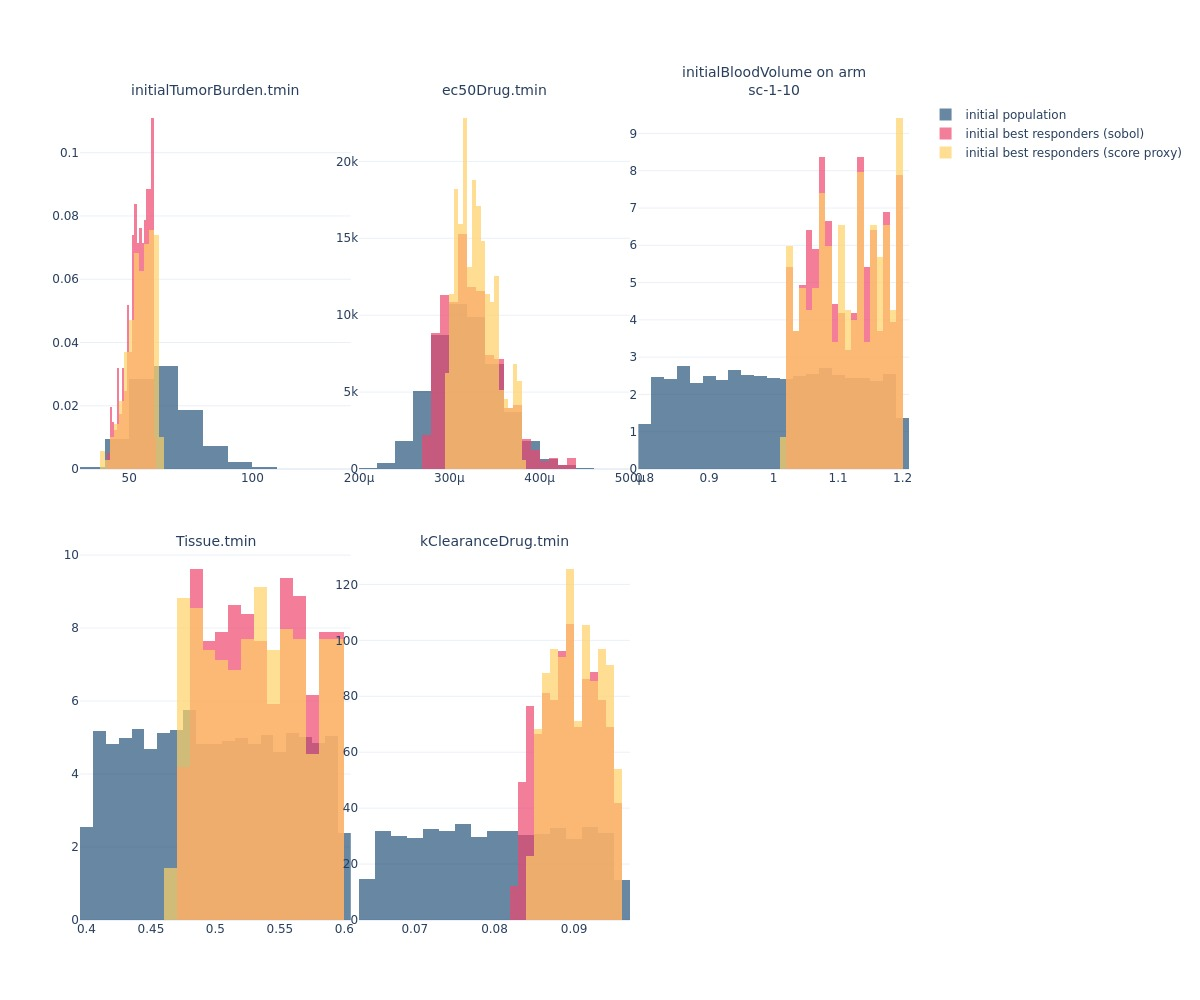

In [14]:
def print_report(criteria, n_boot):
    num_responding = ec.group_size(main_df, criteria)
    print(f"  Number of unique best responding patients: {num_responding}")
    mean_gross_efficacy, sd_gross_efficacy = ec.gross_efficacy_using_bootstrap(
        main_df, criteria, sample_size=trial_sample_size, n_boot=n_boot
    )
    print(f"  Mean of gross efficacy ({n_boot} bootstraps) = {mean_gross_efficacy:.3g}")
    print(
        f"  Standard deviation of gross efficacy ({n_boot} bootstraps) = {sd_gross_efficacy:.2g}"
    )
    control_filtered = main_df[ec.filter_conditions(main_df, criteria)][
        "outcome_control"
    ]
    (best_responders_net_efficacy, _) = ec.net_efficacy(main_df, criteria)
    print(
        f"  Net efficacy in the population of best responders = {best_responders_net_efficacy:.3g}"
    )
    print(
        f"    --> gain in net efficacy = {best_responders_net_efficacy - initial_net_efficacy:.3g} (+{(best_responders_net_efficacy - initial_net_efficacy)/initial_net_efficacy:.0%})"
    )
    control_outcome_std = control_filtered.std()
    best_sample_size = math.ceil(
        sample_size_continuous_outcome(
            alpha, beta, best_responders_net_efficacy, control_outcome_std
        )
    )
    print(
        f"  Required sample size in population of best responders = {best_sample_size}"
    )
    print(
        f"    --> gain in required sample size = {trial_sample_size - best_sample_size} (-{(trial_sample_size - best_sample_size)/trial_sample_size:.0%})"
    )
    mean_gross_efficacy, sd_gross_efficacy = ec.gross_efficacy_using_bootstrap(
        main_df, criteria, sample_size=best_sample_size, n_boot=n_boot
    )
    print(
        f"  Mean of gross efficacy with new sample size ({n_boot} bootstraps) = {mean_gross_efficacy:.3g}"
    )
    print(
        f"  Standard deviation of gross efficacy with new sample size ({n_boot} bootstraps) = {sd_gross_efficacy:.2g}"
    )


n_boot = 50
print(f"Net efficacy in initial population = {initial_net_efficacy:.3g}")
mean_gross_efficacy, sd_gross_efficacy = ec.bootstrapped_efficacy(
    main_df, sample_size=trial_sample_size, seeds=[0], n_boot=n_boot
)
print(f"Mean of gross efficacy (with {n_boot} bootstraps) = {mean_gross_efficacy:.3g}")
print(
    f"Standard deviation of gross efficacy (with {n_boot} bootstraps) = {sd_gross_efficacy:.2g}"
)
print(f"Required sample size in initial population = {trial_sample_size}")


print("\nEligibility criteria using Sobol design exhaustive search + MC fine-tuning:")
print_report(exhaustive_mc_fine_tuned_criteria, n_boot=n_boot)

print("\nEligibility criteria using score proxy + MC fine-tuning:")
print_report(score_proxy_mc_fine_tuned_criteria, n_boot=n_boot)


# Histogram plots


def feature_histogram(fig, name, i, j, x, marker_color):
    fig.add_trace(
        go.Histogram(
            name=name,
            x=x,
            histnorm="probability density",
            nbinsx=num_histogram_bins,
            marker_color=marker_color,
            showlegend=show_legend,
        ),
        row=i + 1,
        col=j + 1,
    )


colnames = [f.format_descriptor() for f in features]
dimension = len(colnames)
colnames_wrapped = ["<br>".join(textwrap.wrap(t, width=30)) for t in colnames]
num_rows, num_cols = 2, 3
if num_rows * num_cols < dimension:
    raise Exception(
        f"Not enough rows and columns ({num_rows * num_cols = }) to plot {dimension} parameters"
    )
num_histogram_bins = 21

fig = make_subplots(
    rows=num_rows,
    cols=num_cols,
    horizontal_spacing=0.01,
    vertical_spacing=0.1,
    subplot_titles=colnames_wrapped,
)
show_legend = True
for i in range(num_rows):
    for j in range(num_cols):
        k = num_cols * i + j
        if k >= dimension:
            continue
        else:
            feature = features[k]
            feature_histogram(
                fig, "initial population", i, j, main_df[feature.column_id], "#26547C"
            )
            feature_histogram(
                fig,
                "initial best responders (sobol)",
                i,
                j,
                main_df.loc[
                    ec.filter_conditions(main_df, exhaustive_mc_fine_tuned_criteria)
                ][feature.column_id],
                "#EF476F",
            )
            feature_histogram(
                fig,
                "initial best responders (score proxy)",
                i,
                j,
                main_df.loc[
                    ec.filter_conditions(main_df, score_proxy_mc_fine_tuned_criteria)
                ][feature.column_id],
                "#FFD166",
            )
            show_legend = False
fig.update_annotations(font_size=14)
figure_width = 1200
figure_height = 1000
fig.update_layout(
    font=dict(size=12),
    showlegend=True,
    barmode="overlay",
    width=figure_width,
    height=figure_height,
    template="plotly_white",
)
fig.update_traces(opacity=0.7)
fig.show(renderer="jpeg")

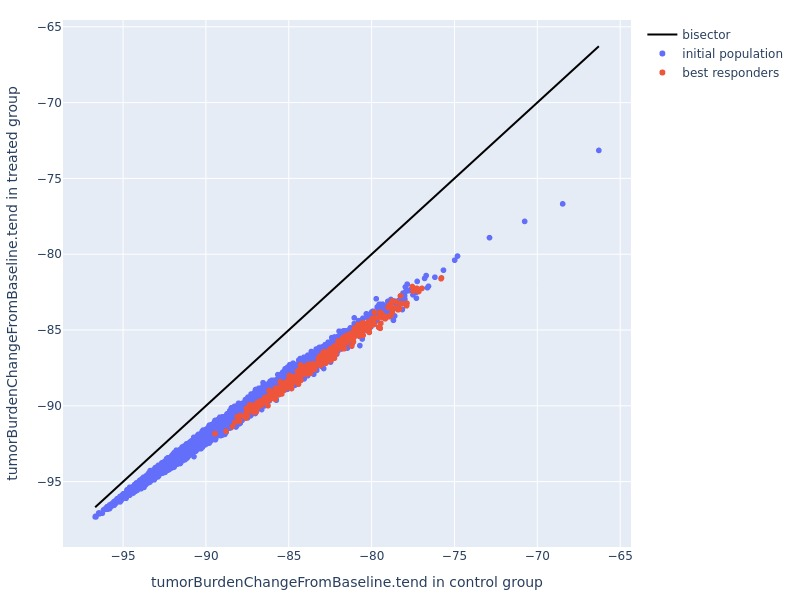

In [15]:
fig = go.Figure()
outcome = main_df["outcome_control"]
bisector = np.array([outcome.min(), outcome.max()])
fig.add_trace(
    go.Scatter(
        x=bisector, y=bisector, mode="lines", line_color="black", name="bisector"
    )
)
fig.add_trace(
    go.Scattergl(
        x=main_df["outcome_control"],
        y=main_df["outcome_treated"],
        mode="markers",
        marker=dict(
            color=colors.qualitative.Plotly[0],
        ),
        name="initial population",
        hoverinfo="none",
    )
)
fig.add_trace(
    go.Scattergl(
        x=main_df[ec.filter_conditions(main_df, score_proxy_mc_fine_tuned_criteria)][
            "outcome_control"
        ],
        y=main_df[ec.filter_conditions(main_df, score_proxy_mc_fine_tuned_criteria)][
            "outcome_treated"
        ],
        mode="markers",
        marker=dict(
            color=colors.qualitative.Plotly[1],
        ),
        name="best responders",
        hoverinfo="none",
    )
)
fig.update_xaxes(title_text=f"{outcome_name} in control group")
fig.update_yaxes(title_text=f"{outcome_name} in treated group")
fig.update_annotations(font_size=12)
fig.update_layout(
    showlegend=True,
    width=800,
    height=600,
    margin=dict(l=50, r=20, t=20, b=20),
)
fig.show(renderer="jpeg")